# 2023-11-29 CEED Fluids

## Last time

* Equations
  * Conservation
  * Choice of variables

## Today
* SUPG stabilization
* Solvers
* Boundary conditions

In [10]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

# Conservation of mass, momentum, and energy

$$\newcommand{\bm}{\mathbf} \frac{\partial \bm{q}}{\partial t} + \nabla \cdot \bm{F}(\bm{q}) -S(\bm{q}) = 0$$


$$\bm{q} =        \begin{pmatrix}            \rho \\             \rho \bm{ u }\\            E \equiv \rho e        \end{pmatrix}        \begin{array}{l}            \leftarrow\textrm{ volume mass density}\\            \leftarrow\textrm{ momentum density}\\            \leftarrow\textrm{ energy density}        \end{array}$$

* Equation of state

\begin{align}
P &= \Big(\underbrace{\frac{c_p}{c_v}}_{\gamma} - 1\Big)\underbrace{\left(E - \frac\rho 2 \bm u \cdot \bm u - \rho g z \right)}_{\rho e_{\text{internal}}} \\
T &= e_{\text{internal}} / c_v
\end{align}

\begin{aligned}
\bm{F}(\bm{q}) &=
\underbrace{\begin{pmatrix}
    \rho\bm{u}\\
    {\rho \bm{u} \otimes \bm{u}} + P \bm{I}_3 \\
    {(E + P)\bm{u}}
\end{pmatrix}}_{\bm F_{\text{adv}}} +
\underbrace{\begin{pmatrix}
0 \\
-  \bm{\sigma} \\
 - \bm{u}  \cdot \bm{\sigma} - k \nabla T
\end{pmatrix}}_{\bm F_{\text{diff}}},\\
S(\bm{q}) &=
- \begin{pmatrix}
    0\\
    \rho g \bm{\hat{k}}\\
    0
\end{pmatrix}.
\end{aligned}


# Choice of variables

## Acoustic wave speed

$$a = \sqrt{c_p(\gamma - 1) T}$$

| material | speed |
|---|---|
| air | 340 m/s |
| water | 1500 m/s |

## Mach number

$$\mathrm{Ma} = \frac{\lVert \bm u \rVert}{a}$$

## Primitive variables

$$\bm y = \begin{pmatrix} P \\ \bm u \\ T \end{pmatrix}$$

Using the equation of state, we can write
$\bm y(\bm q)$ or $\bm q(\bm y)$. But these transformations are **ill conditioned for $\mathrm{Ma} \ll 1$**.

$$ \frac{\partial \bm q}{\partial t} = \frac{\partial \bm q}{\partial \bm y} \frac{\partial \bm y}{\partial t}$$

## Blasius profile (thanks, Leila Ghaffari)

* Take an analytic Blasius profile.
* `Primitive`: Write $\bm y$ in a piecewise linear space with nodally exact values.
* `Conservative`: Write $\bm q$ in a piecewise linear space with nodally exact values.


<img src="img/Temperature_p1.png" />

<img src="img/Temperature_p2.png" />

# Stabilization

\begin{align}
  \int_{\Omega} \bm v \cdot \left( \frac{\partial \bm{q}}{\partial t} - \bm{S}(\bm{y}) \right)  \,dV
  - \int_{\Omega} \nabla \bm v \!:\! \bm{F}(\bm{y})\,dV & \\
  + \int_{\partial \Omega} \bm v \cdot \bm{F}(\bm{y}) \cdot \widehat{\bm{n}} \,dS & \\
  + \int_{\Omega} \nabla \bm v : \frac{\partial \bm F_{\text{adv}}}{\partial \bm q} \bm \tau \left( \frac{\partial \bm{q}}{\partial t} \, + \,
  \nabla \cdot \bm{F} \, (\bm{y}) - \bm{S}(\bm{y}) \right) \,dV &= 0
\end{align}

* Boundary term needs to be replaced with actual boundary conditions
* The strong form term $\nabla\cdot \bm F(\bm y)$
  * is ill-defined at shocks or discontinuous materials
  * involves the second derivative of velocity and temperature; many ignore for linear elements, but [it's better](https://doi.org/10.1016/S0045-7825(98)00284-9) to use a (lumped) projection.

# Time integration

* Fully implicit $G(t, \bm y, \dot{\bm y}) = 0$ with generalized alpha.
* Newton method, usually about 3 iterations per time step.
* Krylov method
  * GMRES when using a strong preconditioner
    * Block Jacobi/incomplete LU
  * BCGS($\ell$) with a weak preconditioner
    * Point-block Jacobi

# Boundary conditions (ref: [Mengaldo et al (2014)](https://doi.org/10.2514/6.2014-2923))

<img src="img/Mengaldo-Fig6.png" />

# Boundary conditions

* Unlike solid mechanics, the "natural" boundary condition is not physical (it's like a free surface). So we need boundary conditions all around.

## Symmetry (free slip)
* Normal velocity = 0, no boundary integral

## Wall (no-slip)
* Total velocity = 0
* Can prescribe temperature (heat sink) or leave it insulated (more complicated for conservative variables)

## Freestream boundaries

* Unified way to handle inflow and outflow (sometimes both).
* Requires solving a "Riemann problem"

## Viscous inflow

* Prescribe velocity and temperature, compute boundary integral for energy flux.

## Viscous outflow
* Prescribe pressure, compute flux with modified ghost pressure $2 P_{\text{ext}} - P_{\text{int}}$
* Compute viscous flux based on interior values

# Convergence to steady state (from Mengaldo)

<img src="img/Mengaldo-Fig7.png" />

# Freestream wave test problem

```
$ mpiexec -n 6 build/fluids-navierstokes -options_file examples/fluids/newtonianwave.yaml
```

## HLL
<video src="img/nwave-hll.webm" loop controls />

## HLLC
<video src="img/nwave-hllc.webm" loop controls />

# Open Problem:
# Turbulent viscous inflow and outflow with non-reflecting boundary conditions.

# Boundary layers for turbulent flow


In [11]:
dymin = 2.66077e-5
alpha_BL = 1.05
dymax_BL = 0.00266077
alpha_OBL = 1.2
dymax_OBL = 0.1
delta = 0.21

function phasta_spacing(n)
    y = zeros(n+1)
    h = zeros(n+1)
    h[1] = dymin
    for i in 2:n+1
        y[i] = y[i-1] + h[i-1]
        h[i] = if y[i] < delta
            min(h[i-1] * alpha_BL, dymax_BL)
        else
            min(h[i-1] * alpha_OBL, dymax_OBL)
        end
    end
    y, h
end

h_IBL(s) = dymin * alpha_BL ^ (s*n)
H_IBL(s) = dymin * alpha_BL ^ (s*n) / log(alpha_BL)

function fractional_spacing(x)
    # find first junction
    x_IBL = log(dymax_BL / dymin) / (n * log(alpha_BL))

    # find second junction by integrating
    y_IBL = H_IBL(x_IBL) - H_IBL(0)
    # find x such that y_IBL + dymax_BL * (x - x_IBL)*n = delta
    x_delta = x_IBL + (delta - y_IBL) / (dymax_BL * n)
    
    # find third junction
    x_OBL = x_delta + log(dymax_OBL / dymax_BL) / (n * log(alpha_OBL))

    if x < x_IBL
        h_IBL(x)
    elseif x < x_delta
        dymax_BL
    elseif x < x_OBL
        dymax_BL * alpha_OBL ^ ((x - x_delta)*n)
    else
        dymax_OBL
    end
end

fractional_spacing (generic function with 1 method)

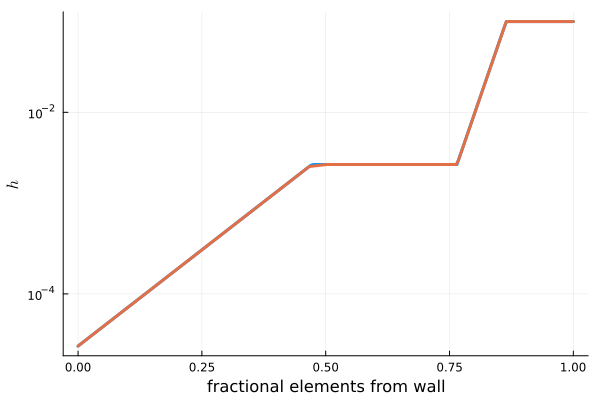

In [16]:
n = 200
y, h = phasta_spacing(n)
plot((0:n)/n, h, yscale=:log10, legend=:none, ylabel="\$h\$", xlabel="fractional elements from wall")
plot!(fractional_spacing)

* Geometric spacing near the wall
  * Aspect ratio $10$ to $10^5$
  * Wall-resolved or wall-modeled
* Turbulent boundary layer
* Far field
* In unstructured CFD, most elements are close to a wall.

# Running on Alpine

```console
$ ssh login.rc.colorado.edu
rc$ module load slurm/alpine
rc$ acompile
acompile$ . /projects/jeka2967/activate.bash
```

```console
$ git clone \
    https://github.com/CEED/libCEED
$ cd libCEED
$ make build/fluids-navierstokes
$ mpiexec -n 1 build/fluids-navierstokes \
    -options_file \
    examples/fluids/gaussianwave.yaml
```

## Running in Docker

Clone the `libCEED` repository and `cd libCEED`
```console
host$ docker run -it --rm -v $(pwd):/work registry.gitlab.com/micromorph/ratel
$ make build/fluids-navierstokes
$ mpiexec -n 2 build/fluids-navierstokes -options_file FILE.yaml
```

# Vortex shedding

## Problem setup

* `examples/fluids/vortexshedding.yaml`
* Mach 0.01
* Reynolds 100

<img src="img/vortexshedding.png" />

<video src="img/cyl-vorticity.webm" loop controls />